In [10]:
import torch
import torch.nn as nn
from torchvision import transforms, models
import numpy as np
import cv2

import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()

        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()

        weights = np.mean(gradients, axis=(2, 3))
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

def preprocess_image(image_path, input_size):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def overlay_cam_on_image(image, cam, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(image)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)

In [53]:
# Load trained brain tumor model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  
    nn.ReLU(),                
    nn.Dropout(0.5),           
    nn.Linear(512, 4)          
)
model.load_state_dict(torch.load('best_brain_tumor_resnet18_finetuned.pth'))

# Select target layer in neural network for Grad CAM
target_layer = model.layer4[-1]  # Replace with the correct target layer

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Preprocess the input image
image_path = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0050.jpg'  # Replace with your image path
input_tensor = preprocess_image(image_path, input_size=(224, 224))

# Generate Grad-CAM
cam = grad_cam.generate_cam(input_tensor)

# Load the original image for visualization
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image = cv2.resize(original_image, (224, 224))

# Overlay CAM on the image
overlay = overlay_cam_on_image(original_image / 255.0, cam)

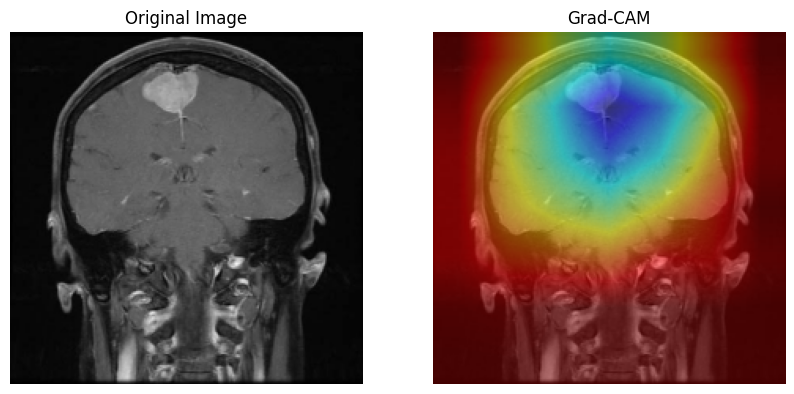

In [54]:
# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.axis('off')

plt.show()